# Anomaly Mini Project

## Project Goals
Answer these questions:

1. Which lesson appears to attract the most traffic consistently across cohorts (per program)?
2. Is there a cohort that referred to a lesson significantly more than other cohorts seemed to gloss over?
3. Are there students who, when active, hardly access the curriculum? If so, what information do you have about these students?
4. Is there any suspicious activity, such as users/machines/etc accessing the curriculum who shouldn’t be? Does it appear that any web-scraping is happening? Are there any suspicious IP addresses?
5. At some point in 2019, the ability for students and alumni to access both curriculums (web dev to ds, ds to web dev) should have been shut off. Do you see any evidence of that happening? Did it happen before?
6. What topics are grads continuing to reference after graduation and into their jobs (for each program)?
7. Which lessons are least accessed?
8. Anything else I should be aware of?

## Project Summary
Questions answered:
* 1. Which lesson appears to attract the most traffic consistently across cohorts (per program)?
* 4. Is there any suspicious activity, such as users/machines/etc accessing the curriculum who shouldn’t be? Does it appear that any web-scraping is happening? Are there any suspicious IP addresses?
* 5. At some point in 2019, the ability for students and alumni to access both curriculums (web dev to ds, ds to web dev) should have been shut off. Do you see any evidence of that happening? Did it happen before?
* 6. What topics are grads continuing to reference after graduation and into their jobs (for each program)?

In [1]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import env
import os
import wrangle

# DBSCAN import
from sklearn.cluster import DBSCAN

# Scaler import
from sklearn.preprocessing import MinMaxScaler

In [2]:
# load data
df = wrangle.prep_logs()

# User Defined Functions

In [3]:
def one_program_df_prep(df, program_name):
    '''
    This function returns a dataframe consisting of data for only a single defined user
    '''
    df = df[df.program == program_name]
    df = df[df.name != 'Staff']
    #df.index = pd.to_datetime(df.date)
    #df = df.set_index(df.date)
    pages_one_program = df['path'].resample('d').count()
    return pages_one_program

def compute_pct_b(pages_one_program, span, weight, program_name):
    '''
    This function adds the %b of a bollinger band range for the page views of a single user's log activity
    '''
    # Calculate upper and lower bollinger band
    midband = pages_one_program.ewm(span=span).mean()
    stdev = pages_one_program.ewm(span=span).std()
    ub = midband + stdev*weight
    lb = midband - stdev*weight
    
    # Add upper and lower band values to dataframe
    bb = pd.concat([ub, lb], axis=1)
    
    # Combine all data into a single dataframe
    my_df = pd.concat([pages_one_program, midband, bb], axis=1)
    my_df.columns = ['pages_one_program', 'midband', 'ub', 'lb']
    
    # Calculate percent b and relevant user id to dataframe
    my_df['pct_b'] = (my_df['pages_one_program'] - my_df['lb'])/(my_df['ub'] - my_df['lb'])
    my_df['program'] = program_name
    return my_df

def plot_bands(my_df, program):
    '''
    This function plots the bolliger bands of the page views for a single user
    '''
    fig, ax = plt.subplots(figsize=(12,8))
    ax.plot(my_df.index, my_df.pages_one_program, label='Number of Pages, Progarm: '+str(program))
    ax.plot(my_df.index, my_df.midband, label = 'EMA/midband')
    ax.plot(my_df.index, my_df.ub, label = 'Upper Band')
    ax.plot(my_df.index, my_df.lb, label = 'Lower Band')
    ax.legend(loc='best')
    ax.set_ylabel('Number of Pages')
    plt.show()
    
def find_anomalies(df, program, span, weight, plot=False):
    '''
    This function returns the records where a user's daily activity exceeded the upper limit of a bollinger band range
    '''
    
    # Reduce dataframe to represent a single user
    pages_one_program = one_program_df_prep(df, program)
    
    # Add bollinger band data to dataframe
    my_df = compute_pct_b(pages_one_program, span, weight, program)
    
    # Plot data if requested (plot=True)
    if plot:
        plot_bands(my_df, program)
    
    # Return only records that sit outside of bollinger band upper limit
    return my_df[my_df.pct_b>1]


In [4]:
def biggest_lesson(df_new, cohort):
    df_new = df_new[df_new.name == cohort]
    df_new = df_new[df_new.path != '/']
    df_new = df_new[df_new.path != 'mkdocs/search_index.json']
    df_new = df_new[df_new.path != 'search/search_index.json']
    df_new = df_new[df_new.path != 'toc']
    df_new = df_new[df_new.path != 'index.html']
    df_new = df_new[df_new.path != 'fundamentals/modern-data-scientist.jpg']
    df_new = df_new[df_new.path != 'fundamentals/AI-ML-DL-timeline.jpg']
    df_new = df_new.dropna()
    #df_new = df_new[df_new.name != 'Everglades']
    df_bigget_lesson = df_new.path.value_counts().idxmax()
    return df_bigget_lesson

def one_program__cohort_df_prep(df, program_name, cohort):
    '''
    This function returns a dataframe consisting of data for only a single defined user
    '''
    df = df[df['name'].notna()]
    df = df[df.program == program_name]
    df = df[df.name != 'Staff']
    df = df[df.name != 'Everglades']
    df = df[df.name == cohort]
    df = df[df.path != '/']
    #df.index = pd.to_datetime(df.date)
    #df = df.set_index(df.date)
    pages_one_program_cohort = df['path'].resample('d').count()
    return pages_one_program_cohort

def biggest_lesson_grad(df_grad, program):
    df_grad = df_grad[df_grad.program == program]
    
    df_grad = df_grad[df_grad.path != 'mkdocs/search_index.json']
    df_grad = df_grad[df_grad.path != 'search/search_index.json']
    df_grad = df_grad[df_grad.path != 'toc']
    df_grad = df_grad[df_grad.path != 'index.html']
    df_grad = df_grad[df_grad.path != 'fundamentals/modern-data-scientist.jpg']
    df_grad = df_grad[df_grad.path != 'fundamentals/AI-ML-DL-timeline.jpg']
    
    df_grad = df_grad.dropna()
    #df_new = df_new[df_new.name != 'Everglades']
    df_bigget_lesson_grad = df_grad.path.value_counts().idxmax()
    return df_bigget_lesson_grad

def one_program__cohort_df_grad_prep(df, program_name, cohort):
    '''
    This function returns a dataframe consisting of data for only a single defined user
    '''
    df = df[df.program == program_name]
    #df = df[df.name != 'Staff']
    df = df[df.name == cohort]
    #df.index = pd.to_datetime(df.date)
    #df = df.set_index(df.date)
    pages_one_program_cohort_grad = df['path'].resample('d').count()
    return pages_one_program_cohort_grad

## 1. Which lesson appears to attract the most traffic consistently across cohorts (per program)?

In [5]:
# set up assembly line
df_lessons = pd.DataFrame()
programs_list = []
lesson_list = []
cohort_list = []

# set up data to run through line
df_new = df[df['name'].notna()]
df_new = df_new[df_new.name != 'Everglades']

# commence assembly line
for i in list(df_new[df_new.name != 'Staff'].name.unique()):
    big_lesson = biggest_lesson(df_new, i)
    print(big_lesson, ' :', i, ' :' ,df_new[df_new.name == i].program.unique())
    print('-----------------------------------')
    programs_list.extend(df_new[df_new.name == i].program.unique())
    lesson_list.append(big_lesson)
    cohort_list.append(i)

java-iii  : Hampton  : ['Full-Stack PHP']
-----------------------------------
spring  : Teddy  : ['Full-Stack Java']
-----------------------------------
spring  : Sequoia  : ['Full-Stack Java']
-----------------------------------
javascript-i  : Arches  : ['Full-Stack PHP']
-----------------------------------
spring  : Niagara  : ['Full-Stack Java']
-----------------------------------
javascript-i  : Pinnacles  : ['Full-Stack Java']
-----------------------------------
content/laravel/intro  : Quincy  : ['Full-Stack PHP']
-----------------------------------
content/laravel/intro  : Kings  : ['Full-Stack PHP']
-----------------------------------
javascript-i  : Lassen  : ['Full-Stack PHP']
-----------------------------------
java-i  : Mammoth  : ['Full-Stack Java']
-----------------------------------
javascript-i/introduction/working-with-data-types-operators-and-variables  : Glacier  : ['Full-Stack PHP']
-----------------------------------
prework/versioning/github  : Denali  : ['Full-S

In [6]:
# construct data frame from assembly line products
df_lessons = pd.DataFrame(
    {'Lesson': lesson_list,
     'Cohort': cohort_list,
     'Program': programs_list
    })

# display most accessed lessons for programs and cohorts
df_lessons.groupby(['Program', 'Cohort']).Lesson.max()

Program          Cohort    
Data Science     Bayes                  1-fundamentals/1.1-intro-to-data-science
                 Curie                                   6-regression/1-overview
                 Darden                                  classification/overview
                 Easley                 classification/scale_features_or_not.svg
                 Florence                     fundamentals/intro-to-data-science
Full-Stack Java  Andromeda                                          javascript-i
                 Apex                                                   html-css
                 Bash                                               javascript-i
                 Betelgeuse                                         javascript-i
                 Ceres                                              javascript-i
                 Deimos                                             javascript-i
                 Europa                                             javascript-i


In [7]:
# display most accessed lessons for each program
df_lessons.groupby('Program').Lesson.max()

Program
Data Science       fundamentals/intro-to-data-science
Full-Stack Java                                spring
Full-Stack PHP              prework/versioning/github
Name: Lesson, dtype: object

## 4. Is there any suspicious activity, such as users/machines/etc accessing the curriculum who shouldn’t be? Does it appear that any web-scraping is happening? Are there any suspicious IP addresses?

In [8]:
# generate data for DBSCAN 
page_views_anomaly = df.groupby(['user_id'])['path'].agg(['count', 'nunique'])
page_views_anomaly

,count,nunique
user_id,,
1,6190,918
2,1451,146
3,1470,164
4,625,137
5,1561,170
...,...,...
976,22,7
977,82,10
978,34,15


In [9]:
# create the scaler
scaler = MinMaxScaler().fit(page_views_anomaly)

# use the scaler
page_views__anomaly_scaled_array = scaler.transform(page_views_anomaly)
page_views__anomaly_scaled_array[0:10]

array([[0.41592742, 1.        ],
       [0.09744624, 0.15812432],
       [0.09872312, 0.17775354],
       [0.04193548, 0.14830971],
       [0.10483871, 0.18429662],
       [0.08387097, 0.19956379],
       [0.10880376, 0.17557252],
       [0.0297043 , 0.09160305],
       [0.03729839, 0.15485278],
       [0.05174731, 0.14503817]])

In [10]:
# fit DBSCAN to page view data
dbsc = DBSCAN(eps = 0.1, min_samples=4).fit(page_views__anomaly_scaled_array)

columns = list(page_views_anomaly.columns)
scaled_columns = ["scaled_" + column for column in columns]

scaled_df = pd.DataFrame(page_views__anomaly_scaled_array,
                         columns=scaled_columns,
                         index=page_views_anomaly.index
                        )

# Merge the scaled and non-scaled values into one dataframe
page_views_anomaly = page_views_anomaly.merge(scaled_df, left_index=True, right_index=True)

# assign variable to labels
labels = dbsc.labels_

#add labels back to the dataframe
page_views_anomaly['labels'] = labels

In [11]:
# how many unique labels (clusters) are created by DBSCAN?
page_views_anomaly.labels.value_counts()

 0    957
-1      7
Name: labels, dtype: int64

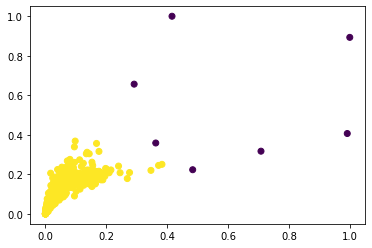

In [12]:
plt.scatter(page_views_anomaly['scaled_count'], page_views_anomaly['scaled_nunique'], c=page_views_anomaly.labels)
plt.show()

### Now lets look at the ip using dbscan to see any anomalies

In [13]:
page_views_ip = df.groupby(['ip', 'user_id'])['path'].agg(['count', 'nunique'])
page_views_ip

,,count,nunique
ip,user_id,,
100.11.170.135,658,86,17
100.19.73.35,658,242,47
100.35.67.162,52,10,7
103.137.12.164,469,9,8
103.208.220.143,369,1,1
...,...,...,...
99.97.210.12,606,16,11
99.98.245.245,618,2,2
99.98.32.165,324,254,97


In [14]:
# create the scaler
scaler = MinMaxScaler().fit(page_views_ip)

# use the scaler
page_views_ip_scaled_array = scaler.transform(page_views_ip)

#######
dbsc = DBSCAN(eps = 0.1, min_samples=4).fit(page_views_ip_scaled_array)

columns = list(page_views_ip.columns)
scaled_columns = ["scaled_" + column for column in columns]

scaled_df = pd.DataFrame(page_views_ip_scaled_array, columns=scaled_columns, index=page_views_ip.index)


# Merge the scaled and non-scaled values into one dataframe
page_views_ip = page_views_ip.merge(scaled_df, left_index=True, right_index=True)

labels = dbsc.labels_

#add labels back to the dataframe
page_views_ip['labels'] = labels

# how many unique labels (clusters) are created by DBSCAN?
page_views_ip.labels.value_counts()

 0    7036
-1       9
Name: labels, dtype: int64

In [15]:
page_views_ip[page_views_ip.labels==-1]

count  nunique  scaled_count  scaled_nunique  labels
ip             user_id                                                      
71.150.217.33  64        6162      262      1.000000        0.452340      -1
76.185.131.226 11        2031      416      0.329492        0.719237      -1
76.185.145.231 11        3870      317      0.627982        0.547660      -1
97.105.19.58   1         2606      578      0.422821        1.000000      -1
               11        5956      557      0.966564        0.963605      -1
               53        4199      208      0.681383        0.358752      -1
               64        5268      228      0.854894        0.393414      -1
               248       1923      406      0.311962        0.701906      -1
               404       1139      294      0.184710        0.507799      -1

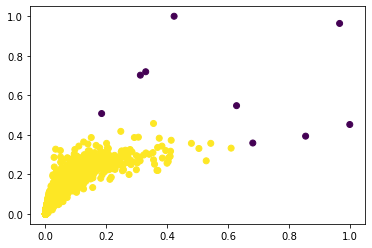

In [16]:
plt.scatter(page_views_ip['scaled_count'], page_views_ip['scaled_nunique'], c=page_views_ip.labels)
plt.show()

In [17]:
# records for user 404
df[df.user_id == 404]

,path,user_id,cohort_id,ip,name,start_date,end_date,created_at,updated_at,program_id,program,is_staff
date_time,,,,,,,,,,,,
2019-05-09 14:14:02,git,404,28.0,97.105.19.58,Staff,2014-02-04,2014-02-04,2018-12-06 17:04:19,2018-12-06 17:04:19,2.0,Full-Stack Java,False
2019-05-09 14:49:48,git,404,28.0,97.105.19.58,Staff,2014-02-04,2014-02-04,2018-12-06 17:04:19,2018-12-06 17:04:19,2.0,Full-Stack Java,False
2019-05-09 15:04:36,open_data,404,28.0,97.105.19.58,Staff,2014-02-04,2014-02-04,2018-12-06 17:04:19,2018-12-06 17:04:19,2.0,Full-Stack Java,False
2019-05-09 15:04:38,git,404,28.0,97.105.19.58,Staff,2014-02-04,2014-02-04,2018-12-06 17:04:19,2018-12-06 17:04:19,2.0,Full-Stack Java,False
2019-05-09 16:06:19,13.02_Tableau,404,28.0,97.105.19.58,Staff,2014-02-04,2014-02-04,2018-12-06 17:04:19,2018-12-06 17:04:19,2.0,Full-Stack Java,False
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-11-25 15:18:51,12-distributed-ml/3-spark-api,404,28.0,97.105.19.58,Staff,2014-02-04,2014-02-04,2018-12-06 17:04:19,2018-12-06 17:04:19,2.0,Full-Stack Java,False
2019-11-25 15:51:06,10-anomaly-detection/1-overview,404,28.0,97.105.19.58,Staff,2014-02-04,2014-02-04,2018-12-06 17:04:19,2018-12-06 17:04:19,2.0,Full-Stack Java,False
2019-11-25 15:51:06,10-anomaly-detection/AnomalyDetectionCartoon.jpeg,404,28.0,97.105.19.58,Staff,2014-02-04,2014-02-04,2018-12-06 17:04:19,2018-12-06 17:04:19,2.0,Full-Stack Java,False


In [18]:
# records for user 248
df[df.user_id == 248]

,path,user_id,cohort_id,ip,name,start_date,end_date,created_at,updated_at,program_id,program,is_staff
date_time,,,,,,,,,,,,
2018-09-07 14:54:13,html-css,248,1.0,97.105.19.58,Arches,2014-02-04,2014-04-22,2016-06-14 19:52:26,2016-06-14 19:52:26,1.0,Full-Stack PHP,False
2018-09-07 14:56:07,html-css/introduction,248,1.0,97.105.19.58,Arches,2014-02-04,2014-04-22,2016-06-14 19:52:26,2016-06-14 19:52:26,1.0,Full-Stack PHP,False
2018-09-07 14:57:00,html-css/elements,248,1.0,97.105.19.58,Arches,2014-02-04,2014-04-22,2016-06-14 19:52:26,2016-06-14 19:52:26,1.0,Full-Stack PHP,False
2018-09-07 14:57:42,html-css/forms,248,1.0,97.105.19.58,Arches,2014-02-04,2014-04-22,2016-06-14 19:52:26,2016-06-14 19:52:26,1.0,Full-Stack PHP,False
2018-09-07 14:58:10,html-css/css-i,248,1.0,97.105.19.58,Arches,2014-02-04,2014-04-22,2016-06-14 19:52:26,2016-06-14 19:52:26,1.0,Full-Stack PHP,False
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-20 10:02:09,fundamentals/intro-to-data-science,248,28.0,173.173.115.201,Staff,2014-02-04,2014-02-04,2018-12-06 17:04:19,2018-12-06 17:04:19,2.0,Full-Stack Java,False
2021-04-20 10:02:09,fundamentals/diagram-of-ds-pipeline-fraud-exam...,248,28.0,173.173.115.201,Staff,2014-02-04,2014-02-04,2018-12-06 17:04:19,2018-12-06 17:04:19,2.0,Full-Stack Java,False
2021-04-20 10:02:14,sql/mysql-overview,248,28.0,173.173.115.201,Staff,2014-02-04,2014-02-04,2018-12-06 17:04:19,2018-12-06 17:04:19,2.0,Full-Stack Java,False


In [19]:
# records for user 64
df[df.user_id == 64]

,path,user_id,cohort_id,ip,name,start_date,end_date,created_at,updated_at,program_id,program,is_staff
date_time,,,,,,,,,,,,
2018-01-29 13:51:00,mkdocs/search_index.json,64,1.0,97.105.19.61,Arches,2014-02-04,2014-04-22,2016-06-14 19:52:26,2016-06-14 19:52:26,1.0,Full-Stack PHP,False
2018-01-29 13:51:04,mysql/users,64,1.0,97.105.19.61,Arches,2014-02-04,2014-04-22,2016-06-14 19:52:26,2016-06-14 19:52:26,1.0,Full-Stack PHP,False
2018-01-30 10:13:12,spring,64,1.0,97.105.19.61,Arches,2014-02-04,2014-04-22,2016-06-14 19:52:26,2016-06-14 19:52:26,1.0,Full-Stack PHP,False
2018-01-30 10:13:14,spring/fundamentals/repositories,64,1.0,97.105.19.61,Arches,2014-02-04,2014-04-22,2016-06-14 19:52:26,2016-06-14 19:52:26,1.0,Full-Stack PHP,False
2018-01-30 10:13:28,spring/fundamentals/relationships,64,1.0,97.105.19.61,Arches,2014-02-04,2014-04-22,2016-06-14 19:52:26,2016-06-14 19:52:26,1.0,Full-Stack PHP,False
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-21 16:41:49,jquery,64,28.0,71.150.217.33,Staff,2014-02-04,2014-02-04,2018-12-06 17:04:19,2018-12-06 17:04:19,2.0,Full-Stack Java,False
2021-04-21 16:41:51,jquery/personal-site,64,28.0,71.150.217.33,Staff,2014-02-04,2014-02-04,2018-12-06 17:04:19,2018-12-06 17:04:19,2.0,Full-Stack Java,False
2021-04-21 16:42:02,jquery/mapbox-api,64,28.0,71.150.217.33,Staff,2014-02-04,2014-02-04,2018-12-06 17:04:19,2018-12-06 17:04:19,2.0,Full-Stack Java,False


In [20]:
# records for user 53
df[df.user_id == 53]

,path,user_id,cohort_id,ip,name,start_date,end_date,created_at,updated_at,program_id,program,is_staff
date_time,,,,,,,,,,,,
2018-01-28 18:48:24,html-css,53,14.0,67.10.161.55,Lassen,2016-07-18,2016-11-10,2016-07-18 19:06:27,2016-07-18 19:06:27,1.0,Full-Stack PHP,False
2018-01-28 18:49:20,javascript-i,53,14.0,67.10.161.55,Lassen,2016-07-18,2016-11-10,2016-07-18 19:06:27,2016-07-18 19:06:27,1.0,Full-Stack PHP,False
2018-01-28 18:49:23,javascript-i/conditionals,53,14.0,67.10.161.55,Lassen,2016-07-18,2016-11-10,2016-07-18 19:06:27,2016-07-18 19:06:27,1.0,Full-Stack PHP,False
2018-01-28 18:50:41,javascript-i/conditionals,53,14.0,67.10.161.55,Lassen,2016-07-18,2016-11-10,2016-07-18 19:06:27,2016-07-18 19:06:27,1.0,Full-Stack PHP,False
2018-01-28 18:51:05,javascript-i/loops,53,14.0,67.10.161.55,Lassen,2016-07-18,2016-11-10,2016-07-18 19:06:27,2016-07-18 19:06:27,1.0,Full-Stack PHP,False
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-20 09:53:31,capstone,53,28.0,65.43.115.179,Staff,2014-02-04,2014-02-04,2018-12-06 17:04:19,2018-12-06 17:04:19,2.0,Full-Stack Java,False
2021-04-20 09:53:33,capstone/sw-project-planning,53,28.0,65.43.115.179,Staff,2014-02-04,2014-02-04,2018-12-06 17:04:19,2018-12-06 17:04:19,2.0,Full-Stack Java,False
2021-04-20 11:14:25,java-iii,53,28.0,65.43.115.179,Staff,2014-02-04,2014-02-04,2018-12-06 17:04:19,2018-12-06 17:04:19,2.0,Full-Stack Java,False


In [21]:
# records for user 11
df[df.user_id == 11]

,path,user_id,cohort_id,ip,name,start_date,end_date,created_at,updated_at,program_id,program,is_staff
date_time,,,,,,,,,,,,
2018-01-26 10:14:51,javascript-i,11,1.0,97.105.19.61,Arches,2014-02-04,2014-04-22,2016-06-14 19:52:26,2016-06-14 19:52:26,1.0,Full-Stack PHP,False
2018-01-26 10:15:02,javascript-i/functions,11,1.0,97.105.19.61,Arches,2014-02-04,2014-04-22,2016-06-14 19:52:26,2016-06-14 19:52:26,1.0,Full-Stack PHP,False
2018-01-26 11:46:39,appendix,11,1.0,97.105.19.61,Arches,2014-02-04,2014-04-22,2016-06-14 19:52:26,2016-06-14 19:52:26,1.0,Full-Stack PHP,False
2018-01-26 11:46:47,appendix/further-reading/javascript/hoisting,11,1.0,97.105.19.61,Arches,2014-02-04,2014-04-22,2016-06-14 19:52:26,2016-06-14 19:52:26,1.0,Full-Stack PHP,False
2018-01-26 11:47:01,appendix/capstone-workbook,11,1.0,97.105.19.61,Arches,2014-02-04,2014-04-22,2016-06-14 19:52:26,2016-06-14 19:52:26,1.0,Full-Stack PHP,False
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-21 09:43:44,anomaly-detection/AnomalyDetectionCartoon.jpeg,11,28.0,76.185.131.226,Staff,2014-02-04,2014-02-04,2018-12-06 17:04:19,2018-12-06 17:04:19,2.0,Full-Stack Java,False
2021-04-21 09:43:45,anomaly-detection/continuous-probabilistic-met...,11,28.0,76.185.131.226,Staff,2014-02-04,2014-02-04,2018-12-06 17:04:19,2018-12-06 17:04:19,2.0,Full-Stack Java,False
2021-04-21 14:21:05,fundamentals/intro-to-data-science,11,28.0,76.185.131.226,Staff,2014-02-04,2014-02-04,2018-12-06 17:04:19,2018-12-06 17:04:19,2.0,Full-Stack Java,False


In [22]:
# records for user 1
df[df.user_id == 1]

,path,user_id,cohort_id,ip,name,start_date,end_date,created_at,updated_at,program_id,program,is_staff
date_time,,,,,,,,,,,,
2018-01-26 09:56:02,java-ii,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1.0,Full-Stack PHP,False
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1.0,Full-Stack PHP,False
2018-01-26 09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1.0,Full-Stack PHP,False
2018-01-26 10:40:15,javascript-i/functions,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1.0,Full-Stack PHP,False
2018-01-26 11:26:13,java-i,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1.0,Full-Stack PHP,False
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-21 09:13:47,sql/mysql-overview,1,28.0,70.121.199.82,Staff,2014-02-04,2014-02-04,2018-12-06 17:04:19,2018-12-06 17:04:19,2.0,Full-Stack Java,False
2021-04-21 09:13:54,python/dataframes,1,28.0,70.121.199.82,Staff,2014-02-04,2014-02-04,2018-12-06 17:04:19,2018-12-06 17:04:19,2.0,Full-Stack Java,False
2021-04-21 10:32:22,sql/mysql-overview,1,28.0,70.121.199.82,Staff,2014-02-04,2014-02-04,2018-12-06 17:04:19,2018-12-06 17:04:19,2.0,Full-Stack Java,False


These users are all staff. Maybe not at first, but most became staff.

## 5. At some point in 2019, the ability for students and alumni to access both curriculums (web dev to ds, ds to web dev) should have been shut off. Do you see any evidence of that happening? Did it happen before?

In [23]:
# gather data from 2019 in a frame
data_2019 = df[(df.index > '2018-12-31 23:59:59') & (df.index < '2020-01-01 00:00:00')]

# resample 2019 path data by day
daily_2019 = data_2019['path'].resample('D').count()
daily_2019

# resample all path data by day
daily_activity = df['path'].resample('D').count()
daily_activity

date_time
2018-01-26     478
2018-01-27     169
2018-01-28     127
2018-01-29     714
2018-01-30     582
              ... 
2021-04-17     412
2021-04-18     545
2021-04-19    1866
2021-04-20    1686
2021-04-21     982
Freq: D, Name: path, Length: 1182, dtype: int64

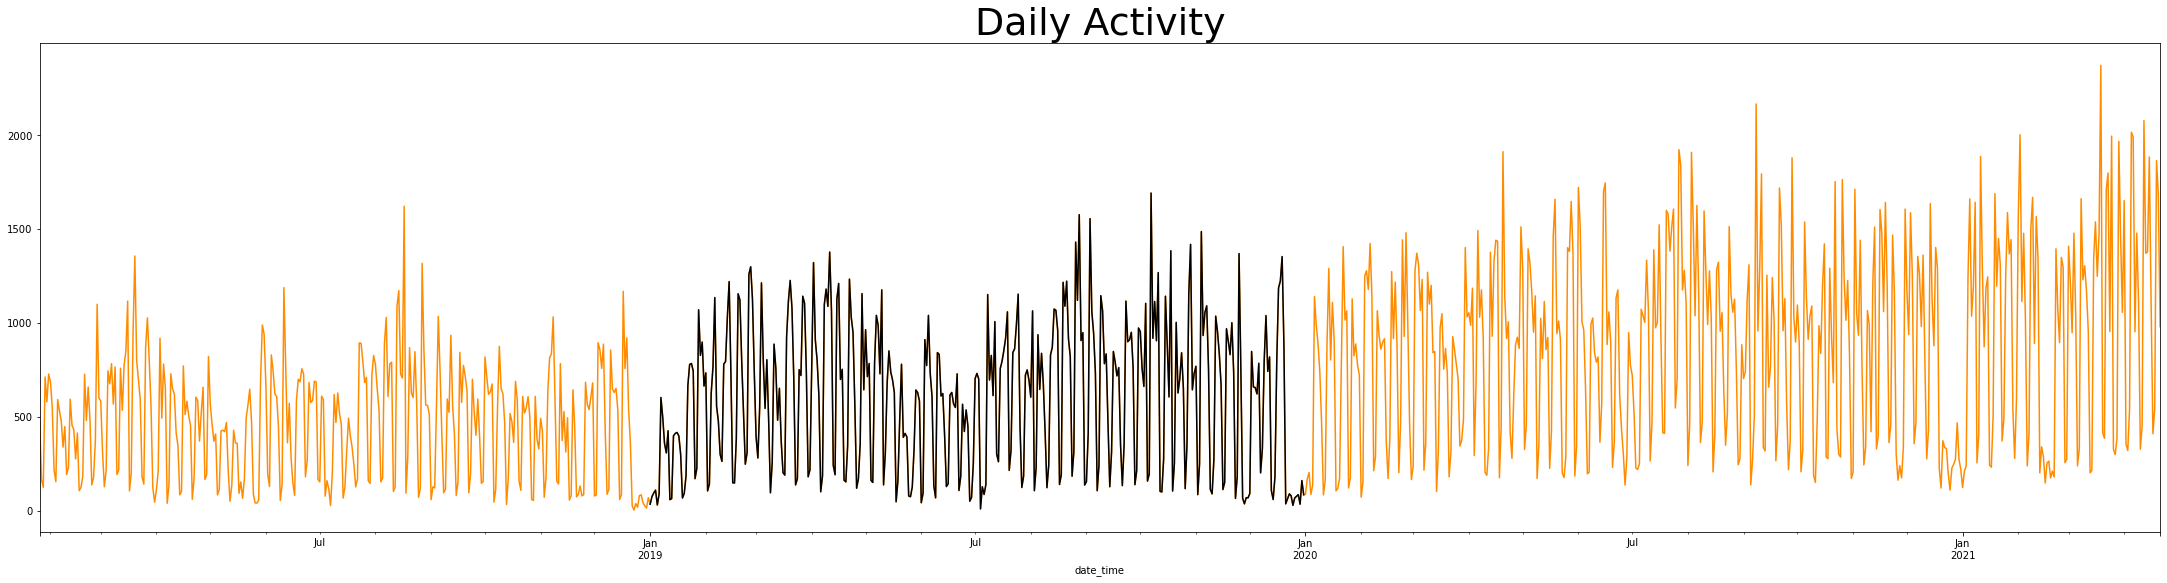

In [24]:
# create figure
plt.figure(figsize = (38, 9))

# plot number of paths taken per day
daily_activity.plot(color = 'darkorange')
daily_2019.plot(color = 'black')
plt.title('Daily Activity', size = 38);

I'm not picking up on anything here to help indicate a shutdown on curriculum-supported cross-reserach. I attrubute large seasonal gaps to the winter break. Let's try looking at the programs paths manually.

In [25]:
# assign variables to 2019 respective program data
full_stack_php = data_2019[data_2019.program_id == 1.0]
full_stack_java = data_2019[data_2019.program_id == 2.0]
data_science = data_2019[data_2019.program_id == 3.0]
front_end = data_2019[data_2019.program_id == 4.0]

In [26]:
# look at largest values and counts for paths for users in the java program
print('2019 Most Accessed Paths from the Full-Stack Java Program')
print('---------------------------------------------')
print(full_stack_java.path.value_counts().nlargest(30))
print(' ')

# view largest values and counts for the paths of data science students
print('2019 Most Accessed Logs from the Data Science Program')
print('-----------------------------------------------------')
data_science.path.value_counts().nlargest(30)

2019 Most Accessed Paths from the Full-Stack Java Program
---------------------------------------------
javascript-i                                                                 4404
search/search_index.json                                                     4277
html-css                                                                     3351
java-iii                                                                     3012
spring                                                                       2950
java-ii                                                                      2912
jquery                                                                       2709
mysql                                                                        2683
java-i                                                                       2603
javascript-ii                                                                2496
html-css/elements                                                           

1-fundamentals/1.1-intro-to-data-science             486
6-regression/1-overview                              399
search/search_index.json                             335
6-regression/5.0-evaluate                            289
5-stats/3-probability-distributions                  282
5-stats/4.2-compare-means                            275
10-anomaly-detection/AnomalyDetectionCartoon.jpeg    274
10-anomaly-detection/1-overview                      273
appendix/cli-git-overview                            267
6-regression/7.0-model                               257
4-python/7.4.3-dataframes                            248
6-regression/4.0-explore                             240
6-regression/3.0-split-and-scale                     234
7-classification/project                             226
6-regression/6.0-feature-engineering                 215
4-python/7.4.4-advanced-dataframes                   211
5-stats/2-simulation                                 209
7-classification/3-prep        

In [27]:
# look at records where users in java program viewed regression material in the curriculum
cross_activity = full_stack_java[(full_stack_java.path.str.contains('regression') == True) & (full_stack_java.name != 'Staff')]
cross_activity

,path,user_id,cohort_id,ip,name,start_date,end_date,created_at,updated_at,program_id,program,is_staff
date_time,,,,,,,,,,,,
2019-07-11 16:34:16,5-regression/1-overview,344,29.0,70.122.40.62,Zion,2019-01-22,2019-06-04,2019-01-20 23:18:57,2019-01-20 23:18:57,2.0,Full-Stack Java,False
2019-08-02 09:14:21,6-regression/1-overview,18,22.0,45.20.117.182,Teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,2.0,Full-Stack Java,False
2019-08-23 11:46:24,6-regression/1-overview,410,32.0,97.105.19.58,Betelgeuse,2019-05-28,2019-10-08,2019-05-28 18:41:05,2019-05-28 18:41:05,2.0,Full-Stack Java,False
2019-09-01 00:03:01,6-regression/1-overview,18,22.0,45.20.117.182,Teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,2.0,Full-Stack Java,False
2019-09-01 00:03:04,6-regression/2-regression-excel,18,22.0,45.20.117.182,Teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,2.0,Full-Stack Java,False
2019-10-02 16:31:58,6-regression/1-overview,41,21.0,97.105.19.58,Sequoia,2017-09-27,2018-02-15,2017-09-27 20:22:41,2017-09-27 20:22:41,2.0,Full-Stack Java,False
2019-10-02 16:32:04,6-regression/3.3-explore,41,21.0,97.105.19.58,Sequoia,2017-09-27,2018-02-15,2017-09-27 20:22:41,2017-09-27 20:22:41,2.0,Full-Stack Java,False
2019-10-02 16:32:05,6-regression/3.1-acquire-and-prep,41,21.0,97.105.19.58,Sequoia,2017-09-27,2018-02-15,2017-09-27 20:22:41,2017-09-27 20:22:41,2.0,Full-Stack Java,False
2019-10-08 11:43:03,6-regression/1-overview,458,33.0,97.105.19.58,Ceres,2019-07-15,2019-12-11,2019-07-15 16:57:21,2019-07-15 16:57:21,2.0,Full-Stack Java,False


These records match the paths most popular from the DS program. I'm gonna go ahead and say these are data science paths.

In [28]:
# view records where data science students had a path that contains 'java'
cross_active = data_science[(data_science.path.str.contains('java') == True) & (data_science.name != 'Staff')]
cross_active

,path,user_id,cohort_id,ip,name,start_date,end_date,created_at,updated_at,program_id,program,is_staff
date_time,,,,,,,,,,,,
2019-09-23 11:45:09,java-iii,476,34.0,97.105.19.58,Bayes,2019-08-19,2020-01-30,2019-08-20 14:38:55,2019-08-20 14:38:55,3.0,Data Science,False
2019-09-25 19:30:44,javascript-i,476,34.0,136.50.49.145,Bayes,2019-08-19,2020-01-30,2019-08-20 14:38:55,2019-08-20 14:38:55,3.0,Data Science,False
2019-09-25 19:31:07,javascript-i,476,34.0,136.50.49.145,Bayes,2019-08-19,2020-01-30,2019-08-20 14:38:55,2019-08-20 14:38:55,3.0,Data Science,False
2019-09-25 19:31:11,java-i,476,34.0,136.50.49.145,Bayes,2019-08-19,2020-01-30,2019-08-20 14:38:55,2019-08-20 14:38:55,3.0,Data Science,False
2019-09-25 19:31:12,javascript-i,476,34.0,136.50.49.145,Bayes,2019-08-19,2020-01-30,2019-08-20 14:38:55,2019-08-20 14:38:55,3.0,Data Science,False
2019-09-25 19:31:14,java-i,476,34.0,136.50.49.145,Bayes,2019-08-19,2020-01-30,2019-08-20 14:38:55,2019-08-20 14:38:55,3.0,Data Science,False
2019-09-25 19:31:19,java-ii,476,34.0,136.50.49.145,Bayes,2019-08-19,2020-01-30,2019-08-20 14:38:55,2019-08-20 14:38:55,3.0,Data Science,False
2019-09-25 19:32:23,javascript-i,476,34.0,136.50.49.145,Bayes,2019-08-19,2020-01-30,2019-08-20 14:38:55,2019-08-20 14:38:55,3.0,Data Science,False
2019-09-25 19:32:34,java-i,476,34.0,136.50.49.145,Bayes,2019-08-19,2020-01-30,2019-08-20 14:38:55,2019-08-20 14:38:55,3.0,Data Science,False


In [29]:
# look at records where users in java program viewed pandas material in the curriculum
cross_activity2 = full_stack_java[(full_stack_java.path.str.contains('pandas') == True) & (full_stack_java.name != 'Staff')]
cross_activity2.head(2)

,path,user_id,cohort_id,ip,name,start_date,end_date,created_at,updated_at,program_id,program,is_staff
date_time,,,,,,,,,,,,
2019-02-14 22:58:05,4.6.3_introduction_to_pandas,223,25.0,136.50.20.17,Wrangell,2018-07-23,2018-11-29,2018-07-23 15:02:25,2018-07-23 15:02:25,2.0,Full-Stack Java,False
2019-02-18 15:57:32,4.6.3_introduction_to_pandas,187,24.0,167.24.104.150,Voyageurs,2018-05-29,2018-10-11,2018-05-25 22:25:57,2018-05-25 22:25:57,2.0,Full-Stack Java,False


In [30]:
# look at records where users in java program viewed python material in the curriculum
cross_activity3 = full_stack_java[(full_stack_java.path.str.contains('python') == True) & (full_stack_java.name != 'Staff')]
cross_activity3.head(2)

,path,user_id,cohort_id,ip,name,start_date,end_date,created_at,updated_at,program_id,program,is_staff
date_time,,,,,,,,,,,,
2019-07-18 20:33:26,4-python/1-overview,450,33.0,192.171.117.210,Ceres,2019-07-15,2019-12-11,2019-07-15 16:57:21,2019-07-15 16:57:21,2.0,Full-Stack Java,False
2019-07-24 12:28:13,4-python/1-overview,450,33.0,97.105.19.58,Ceres,2019-07-15,2019-12-11,2019-07-15 16:57:21,2019-07-15 16:57:21,2.0,Full-Stack Java,False


In [31]:
# view records where datascience students had a path that contains 'html'
cross_active2 = data_science[(data_science.path.str.contains('html') == True) & (data_science.name != 'Staff')]
cross_active2.head(2)

,path,user_id,cohort_id,ip,name,start_date,end_date,created_at,updated_at,program_id,program,is_staff
date_time,,,,,,,,,,,,
2019-09-25 19:30:42,html-css,476,34.0,136.50.49.145,Bayes,2019-08-19,2020-01-30,2019-08-20 14:38:55,2019-08-20 14:38:55,3.0,Data Science,False
2019-09-25 19:30:49,html-css,476,34.0,136.50.49.145,Bayes,2019-08-19,2020-01-30,2019-08-20 14:38:55,2019-08-20 14:38:55,3.0,Data Science,False


In [32]:
# look at records where users in java program viewed statistics material in the curriculum
cross_activity4 = full_stack_java[(full_stack_java.path.str.contains('stats') == True) & (full_stack_java.name != 'Staff')]
cross_activity4.head(2)

,path,user_id,cohort_id,ip,name,start_date,end_date,created_at,updated_at,program_id,program,is_staff
date_time,,,,,,,,,,,,
2019-07-11 14:01:54,2-stats/1-overview,186,24.0,24.243.59.161,Voyageurs,2018-05-29,2018-10-11,2018-05-25 22:25:57,2018-05-25 22:25:57,2.0,Full-Stack Java,False
2019-07-11 16:47:18,2-stats/2.2-navigating-excel,344,29.0,70.122.40.62,Zion,2019-01-22,2019-06-04,2019-01-20 23:18:57,2019-01-20 23:18:57,2.0,Full-Stack Java,False


In [33]:
# look at records where users in java program viewed anomaly material in the curriculum
cross_activity5 = full_stack_java[(full_stack_java.path.str.contains('anomaly') == True) & (full_stack_java.name != 'Staff')]
cross_activity5.head(2)

,path,user_id,cohort_id,ip,name,start_date,end_date,created_at,updated_at,program_id,program,is_staff
date_time,,,,,,,,,,,,
2019-08-02 09:14:25,10-anomaly-detection/1-overview,18,22.0,45.20.117.182,Teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,2.0,Full-Stack Java,False
2019-08-02 09:14:25,10-anomaly-detection/AnomalyDetectionCartoon.jpeg,18,22.0,45.20.117.182,Teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,2.0,Full-Stack Java,False


Let's plot cross activity to see if anything sticks out.

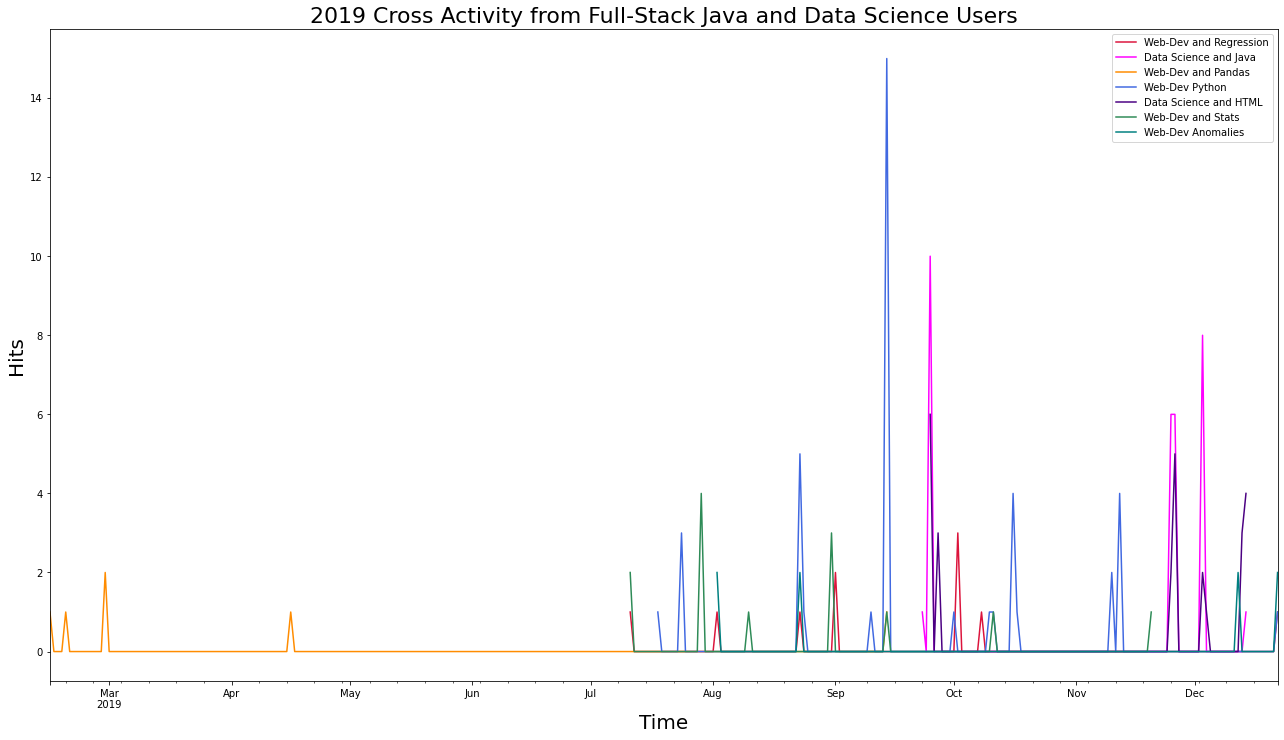

In [34]:
plt.figure(figsize = (22, 12))    # create figure for plots

plt.title('2019 Cross Activity from Full-Stack Java and Data Science Users', size = 22)    # title

java_regression = cross_activity.path.resample('D').count()    # resample web dev users looking up regression

ds_java = cross_active.path.resample('D').count()    # resample data science users looking up java 

java_pandas = cross_activity2.path.resample('D').count()    # resample web dev users looking up pandas

java_python = cross_activity3.path.resample('D').count()    # resample web dev users looking up python

ds_html = cross_active2.path.resample('D').count()    # resample data science users looking up html

java_stats = cross_activity4.path.resample('D').count()    # resample web dev users looking up stats

jawa_anomaly = cross_activity5.path.resample('D').count()    # resample web dev users looking up anomaly material


java_regression.plot(color = 'crimson', label = 'Web-Dev and Regression')   # plot web dev user activity in regards to regression

ds_java.plot(color = 'magenta', label =  'Data Science and Java')    # plot data science user activity in regards to java

java_pandas.plot(color = 'darkorange', label = 'Web-Dev and Pandas')    # plot web dev users looking up pandas

java_python.plot(color = 'royalblue', label = 'Web-Dev Python')    # plot we dev users looking up python

ds_html.plot(color = 'indigo', label = 'Data Science and HTML')    # plot data science users looking up html

java_stats.plot(color = 'seagreen', label = 'Web-Dev and Stats')    # plot web dev users researching stats

jawa_anomaly.plot(color = 'teal', label = 'Web-Dev Anomalies')    # plot web dev users looking up anomaly material

plt.legend()    # include legend

plt.ylabel('Hits', size = 20)    # label y-axis

plt.xlabel('Time', size = 20);    # label x-axis

There appears to be a big gap in cross activity from March to mid-April, and then again from mid-April to mid-July. This is the only evidence found for a supposed shut down.

## 6. What topics are grads continuing to reference after graduation and into their jobs (for each program)?

In [35]:
# assign boolean mask to determine if user has graduated
df['is_grad'] = df.index > df.end_date
df_grad = df[df.is_grad == True]

What topics are they referenceing? main paths per program

In [36]:
# review
df_grad.head()

,path,user_id,cohort_id,ip,name,start_date,end_date,created_at,updated_at,program_id,program,is_staff,is_grad
date_time,,,,,,,,,,,,,
2018-01-26 09:56:02,java-ii,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1.0,Full-Stack PHP,False,True
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1.0,Full-Stack PHP,False,True
2018-01-26 09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1.0,Full-Stack PHP,False,True
2018-01-26 10:14:51,javascript-i,11,1.0,97.105.19.61,Arches,2014-02-04,2014-04-22,2016-06-14 19:52:26,2016-06-14 19:52:26,1.0,Full-Stack PHP,False,True
2018-01-26 10:15:02,javascript-i/functions,11,1.0,97.105.19.61,Arches,2014-02-04,2014-04-22,2016-06-14 19:52:26,2016-06-14 19:52:26,1.0,Full-Stack PHP,False,True


In [37]:
# aggregate grad views across programs
page_views_grad = df_grad[df_grad.name != 'Staff'].groupby(['program'])['path'].agg(['count', 'nunique'])
page_views_grad

,count,nunique
program,,
Data Science,9235,411
Full-Stack Java,64377,642
Full-Stack PHP,23676,465


In [38]:
# a glance at values and counts
df_grad.path.value_counts()

javascript-i                      4969
spring                            4273
search/search_index.json          4183
html-css                          3687
java-iii                          3541
                                  ... 
fundamentals/controllers             1
sgithubtudents/1215                  1
users/1/edit                         1
content/examples/php/Input.php       1
spring/integration-tests             1
Name: path, Length: 1572, dtype: int64

In [39]:
# commence loop to see big lessons accessed for each program post grad 
for i in list(df_grad.program.unique()):
    big_lesson_grad = biggest_lesson_grad(df_grad, i)
    print(big_lesson_grad, ' :', i)
    print('-----------------------------------')

javascript-i  : Full-Stack PHP
-----------------------------------
javascript-i  : Full-Stack Java
-----------------------------------
sql/mysql-overview  : Data Science
-----------------------------------


In [40]:
# commence loop to see which cohorts accessed the biggest lessons post grad
for i in list(df_grad.program.unique()):
    big_lesson_grad = biggest_lesson_grad(df_grad, i)
    print(big_lesson_grad, ' :', i, ' :' ,df_grad[df_grad.program == i].name.unique())
    print('-----------------------------------')

javascript-i  : Full-Stack PHP  : ['Hampton' 'Arches' 'Quincy' 'Kings' 'Lassen' 'Glacier' 'Denali' 'Joshua'
 'Olympic' 'Badlands' 'Ike' 'Franklin']
-----------------------------------
javascript-i  : Full-Stack Java  : ['Niagara' 'Pinnacles' 'Mammoth' 'Sequoia' 'Teddy' 'Ulysses' 'Voyageurs'
 'Wrangell' 'Staff' 'Xanadu' 'Yosemite' 'Zion' 'Andromeda' 'Betelgeuse'
 'Ceres' 'Deimos' 'Europa' 'Fortuna' 'Apex' 'Ganymede' 'Hyperion' 'Bash'
 'Jupiter']
-----------------------------------
sql/mysql-overview  : Data Science  : ['Bayes' 'Curie' 'Darden']
-----------------------------------


### Most popular topics accessed post-graduation by program
* Full-Stack-PHP - javascript
* Full-Stack-Java - javascript
* Front-End - html-css
* Data-Science - mysql

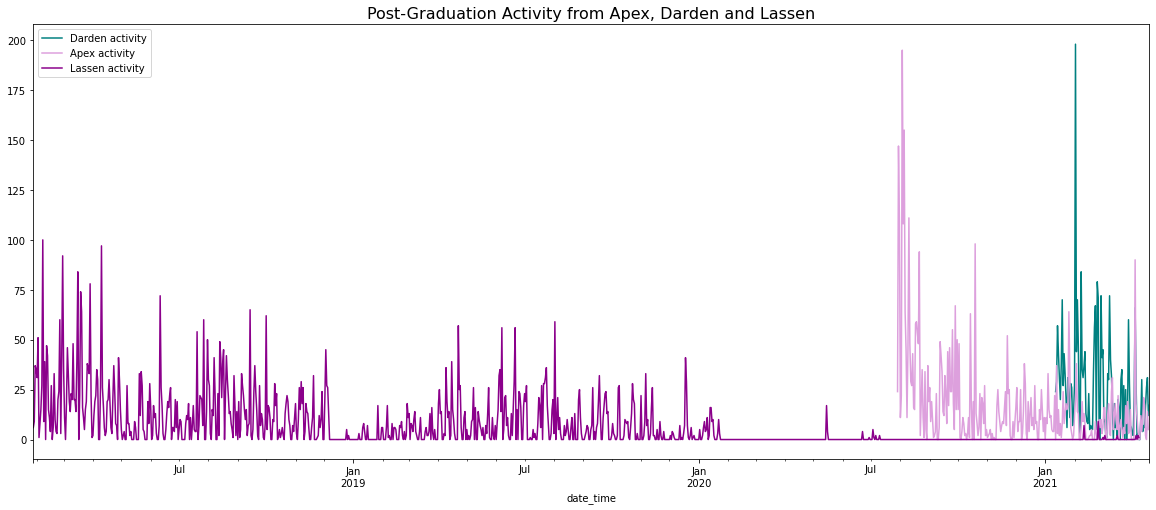

In [41]:
df_data_max_grad = one_program__cohort_df_grad_prep(df_grad, 'Data Science', 'Darden')
df_java_max_grad = one_program__cohort_df_grad_prep(df_grad, 'Full-Stack Java', 'Apex')
df_php_max_grad = one_program__cohort_df_grad_prep(df_grad, 'Full-Stack PHP', 'Lassen')

plt.figure(figsize = (20, 8))
plt.title('Post-Graduation Activity from Apex, Darden and Lassen', size = 16)
df_data_max_grad.plot(color = 'teal', label = 'Darden activity')
df_java_max_grad.plot(color = 'plum', label = 'Apex activity')
df_php_max_grad.plot(color = 'darkmagenta', label = 'Lassen activity')
plt.legend();

We hope this information serves your agenda!